In [51]:
import pandas as pd
import numpy as np

# 1) Chargement
athletes = pd.read_csv('athlete_events.csv')
noc      = pd.read_csv('noc_regions.csv')

# 2) Médailles par pays/sport
data      = pd.merge(athletes, noc, on='NOC', how='left')

#  Exclusion  des NOC historiques/spéciaux
drop_nocs = [
    'ANZ','NFL','HKG','TCH','BOH',
    'FRG','GDR','SAA','CRT','MAL','NBO',
    'URS','EUN','SCG','YUG','UAR','WIF',
    'VNM','YAR','YMD','RHO'
]
data = data[~data['NOC'].isin(drop_nocs)].copy()

medals    = data.dropna(subset=['Medal'])
grouped   = (medals
             .groupby(['NOC','Sport'])
             .size()
             .reset_index(name='podium_count'))

# 3) max_podium & total_medals
max_pod   = grouped.groupby('NOC')['podium_count']\
                   .max()\
                   .rename('max_podium')
total_med = grouped.groupby('NOC')['podium_count']\
                   .sum()\
                   .rename('total_medals')

# 4) calcul de p_i et entropie Shannon
df = grouped.join(total_med, on='NOC')
df['p'] = df['podium_count'] / df['total_medals']

shannon = (df
           .assign(entropy=lambda d: -d['p'] * np.log(d['p']))
           .groupby('NOC')['entropy']
           .sum()
           .rename('H_shannon'))

# 5) nombre de sports S et normalisation
sports_count = grouped.groupby('NOC')['Sport']\
                      .nunique()\
                      .rename('S')

shannon_norm = (pd.concat([shannon, sports_count], axis=1)
                  .assign(H_norm=lambda d: d['H_shannon']/np.log(d['S']))
                  .reset_index())

# 6) corriger les NaN (pays avec S=1 → H_norm=0)
shannon_norm['H_norm'] = shannon_norm['H_norm'].fillna(0)

# 7) fusionner tout dans specialisation
specialisation = (
    max_pod.reset_index()
    .merge(total_med.reset_index(), on='NOC')
    .merge(shannon_norm[['NOC','H_norm']], on='NOC')
    .merge(noc[['NOC','region']], on='NOC', how='left')
)

# 8) calcul du ratio de spécialisation
specialisation['ratio_specialisation'] = (
    specialisation['max_podium']
    / specialisation['total_medals']
)

# 9) renommage et réorganisation
specialisation.rename(columns={'region':'Pays'}, inplace=True)
specialisation = specialisation[
    ['Pays','max_podium','total_medals','ratio_specialisation','H_norm']
]

print(specialisation.head())


          Pays  max_podium  total_medals  ratio_specialisation    H_norm
0  Afghanistan           2             2              1.000000  0.000000
1      Curacao           1             1              1.000000  0.000000
2      Algeria           9            17              0.529412  0.870229
3    Argentina          81           274              0.295620  0.733777
4      Armenia           8            16              0.500000  0.802405


In [52]:
specialisation

,Pays,max_podium,total_medals,ratio_specialisation,H_norm
0,Afghanistan,2,2,1.000000,0.000000
1,Curacao,1,1,1.000000,0.000000
2,Algeria,9,17,0.529412,0.870229
3,Argentina,81,274,0.295620,0.733777
4,Armenia,8,16,0.500000,0.802405
5,Australia,401,1320,0.303788,0.706309
6,Austria,114,450,0.253333,0.829018
7,Azerbaijan,23,44,0.522727,0.750167
8,Bahamas,36,40,0.900000,0.468996
9,Barbados,1,1,1.000000,0.000000


In [53]:
specialisation['Perf_H'] = (
    specialisation['total_medals']
    * specialisation['H_norm']
)


In [54]:
pd.set_option("display.max_rows", None)

In [55]:
pd.reset_option("display.max_rows")

In [56]:
b = specialisation.sort_values(by=['ratio_specialisation'], ascending=False)

In [57]:
# dictionnaire de correspondances 'region' -> 'SOVEREIGNT'
overrides = {
    'USA': 'United States of America',
    'Trinidad': 'Trinidad and Tobago',
    'Serbia': 'Republic of Serbia',
    'Tanzania': 'United Republic of Tanzania',
    'UK': 'United Kingdom',
    'Bahamas': 'The Bahamas',
    'Macedonia': 'North Macedonia',
    'Czech Republic': 'Czechia'
    }

     
specialisation['SOVEREIGNT_corr'] = (
    specialisation['Pays']
    .replace(overrides)
    .astype(str)
)


In [58]:
specialisation

,Pays,max_podium,total_medals,ratio_specialisation,H_norm,Perf_H,SOVEREIGNT_corr
0,Afghanistan,2,2,1.000000,0.000000,0.000000,Afghanistan
1,Curacao,1,1,1.000000,0.000000,0.000000,Curacao
2,Algeria,9,17,0.529412,0.870229,14.793895,Algeria
3,Argentina,81,274,0.295620,0.733777,201.055007,Argentina
4,Armenia,8,16,0.500000,0.802405,12.838484,Armenia
...,...,...,...,...,...,...,...
132,Uzbekistan,14,34,0.411765,0.743234,25.269948,Uzbekistan
133,Venezuela,6,15,0.400000,0.868746,13.031195,Venezuela
134,Vietnam,2,4,0.500000,0.946395,3.785579,Vietnam
135,Zambia,1,2,0.500000,1.000000,2.000000,Zambia


In [59]:
import geopandas as gpd 
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

In [60]:
# on va merge specialisation et world


merged = world.merge(specialisation, 
left_on = 'SOVEREIGNT',
right_on = 'SOVEREIGNT_corr',
how = 'left')

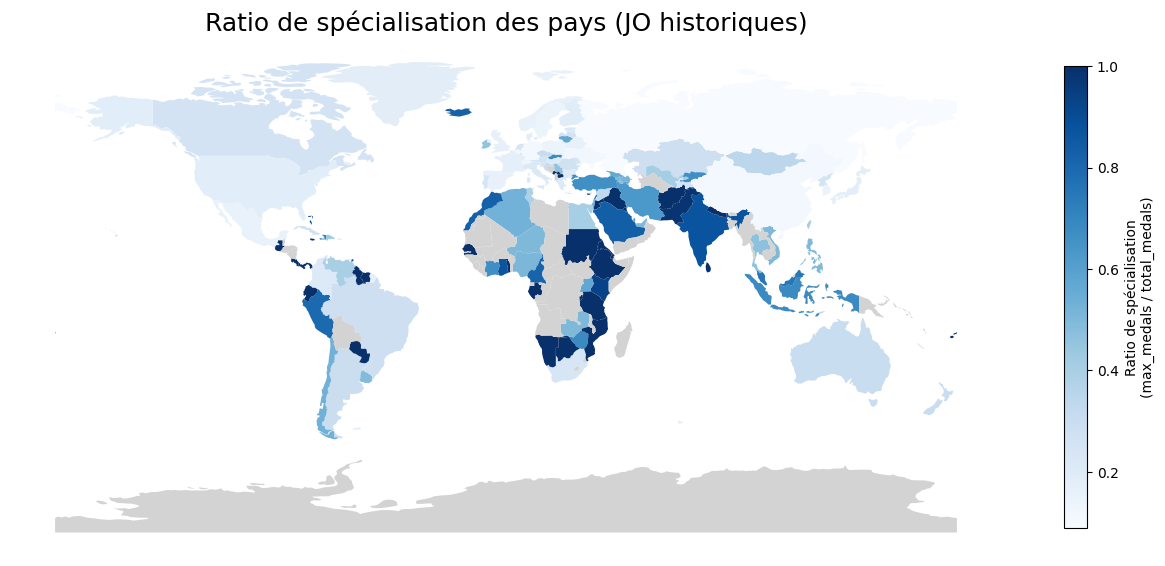

In [61]:
import matplotlib.pyplot as plt

# 5) Trace la choroplèthe
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
merged.plot(
    column='ratio_specialisation',
    ax=ax,
    legend=True,
    cmap = 'Blues',
    legend_kwds={
      'label': "Ratio de spécialisation\n(max_medals / total_medals)",
      'shrink': 0.6
    },
    missing_kwds={
      "color": "lightgrey",
      "label": "Pas de données"
    }
)

ax.set_title("Ratio de spécialisation des pays (JO historiques)", fontsize=18)
ax.set_axis_off()

plt.show()

juste pour voir, tester ce qui se passe si on fait merge = 'right'

In [62]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [63]:
merged['ratio_cat'] = pd.cut(
    merged['ratio_specialisation'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    include_lowest=True,
    labels=['0-0.2','0.2-0.4','0.4-0.6', '0.6-0.8','0.8-1.0']
    )

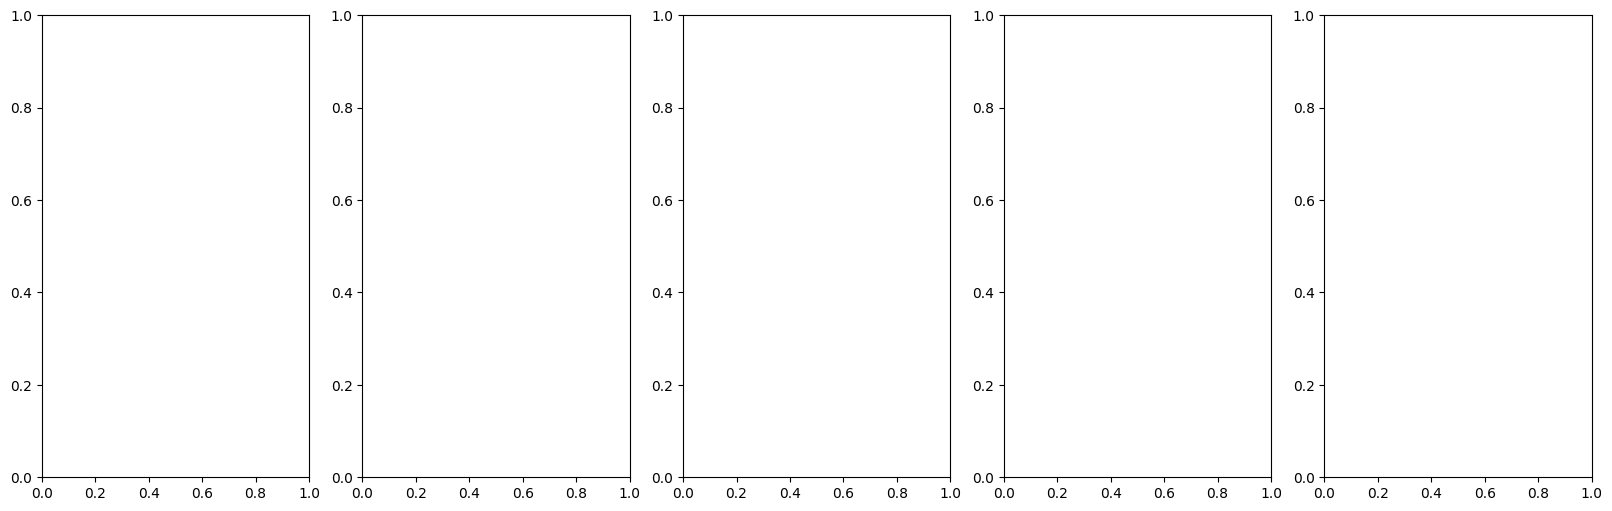

In [64]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))  # plus simple : pas besoin de sharex/sharey ici

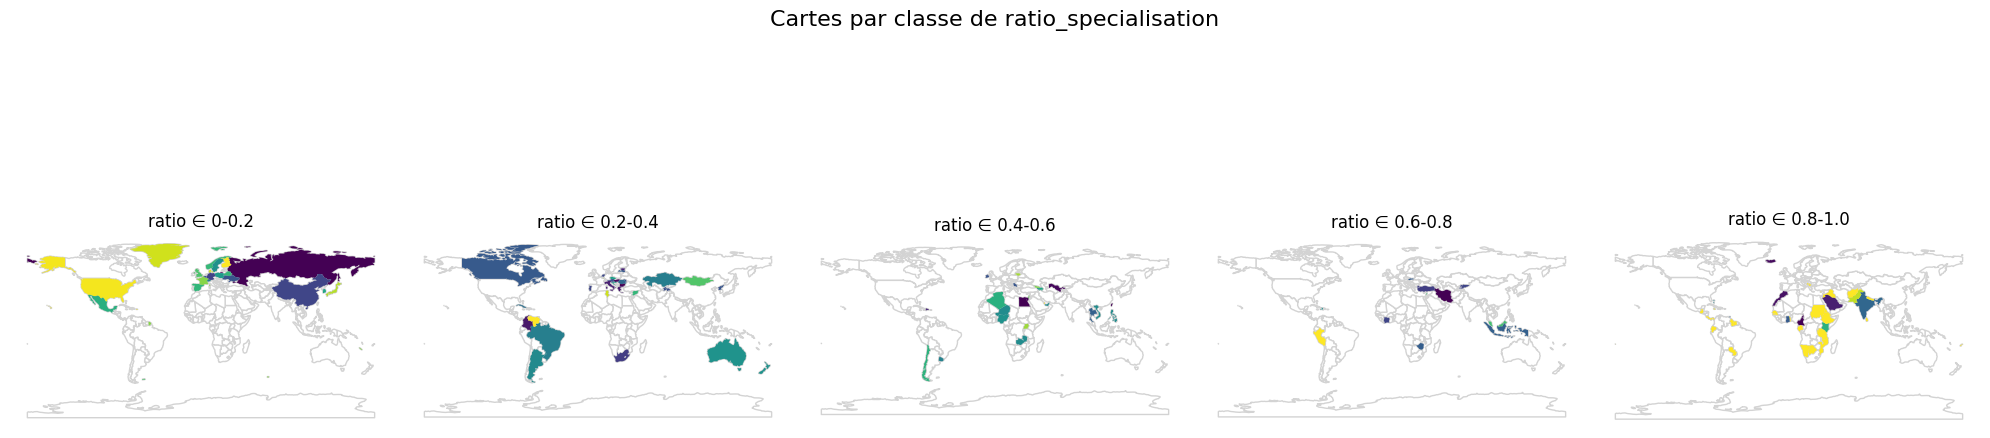

In [65]:
merged['ratio_cat'] = pd.cut(
    merged['ratio_specialisation'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    include_lowest=True,
    labels=['0-0.2','0.2-0.4','0.4-0.6', '0.6-0.8','0.8-1.0']
    )

fig, axes = plt.subplots(1,5,figsize=(20,6), sharex=True, sharey=True)
for ax, cat in zip(axes, merged['ratio_cat'].cat.categories):
    world.plot(
        color='white', 
        edgecolor='lightgrey', 
        ax=ax)
    
    
    subset = merged[merged['ratio_cat'] == cat]
    subset.plot(
        ax=ax,
        column='ratio_specialisation',
        cmap='viridis',
        legend=False
    )
    ax.set_title(f'ratio ∈ {cat}')
    ax.set_axis_off()

plt.suptitle("Cartes par classe de ratio_specialisation", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


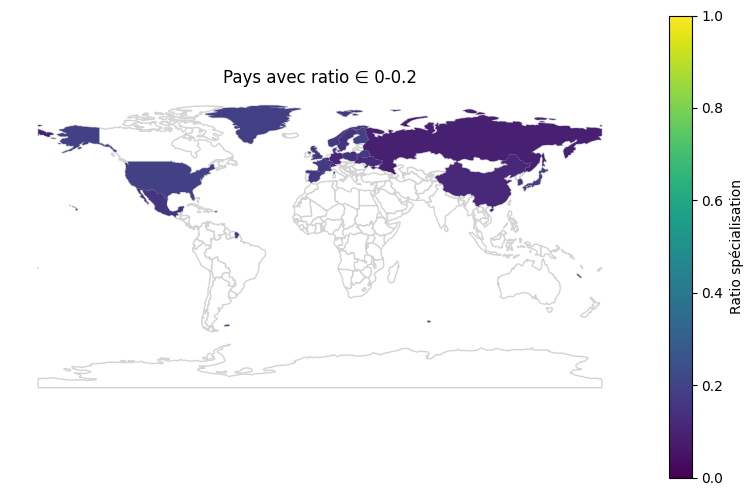

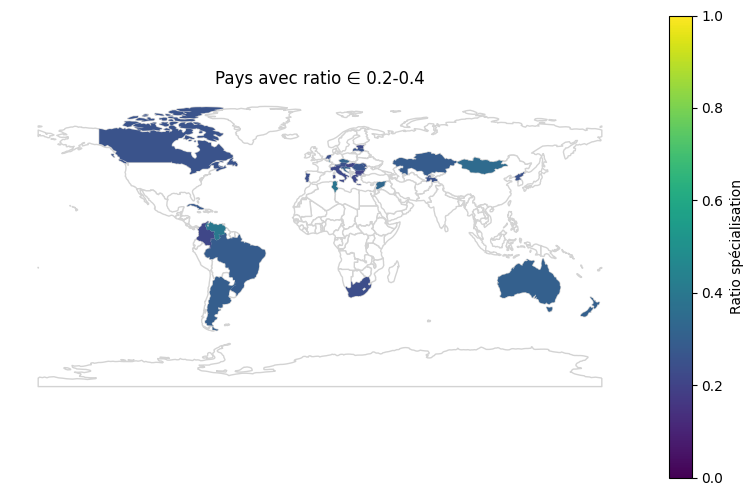

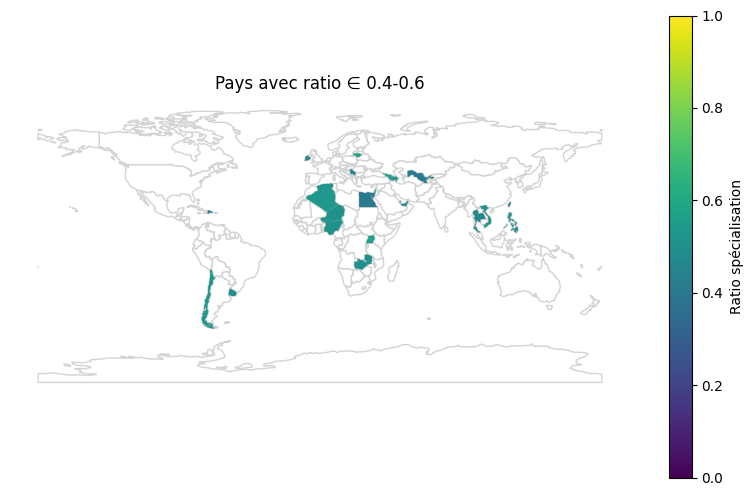

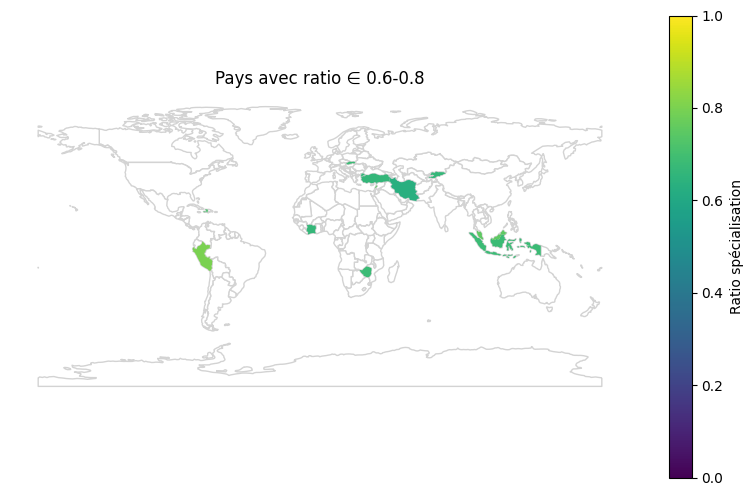

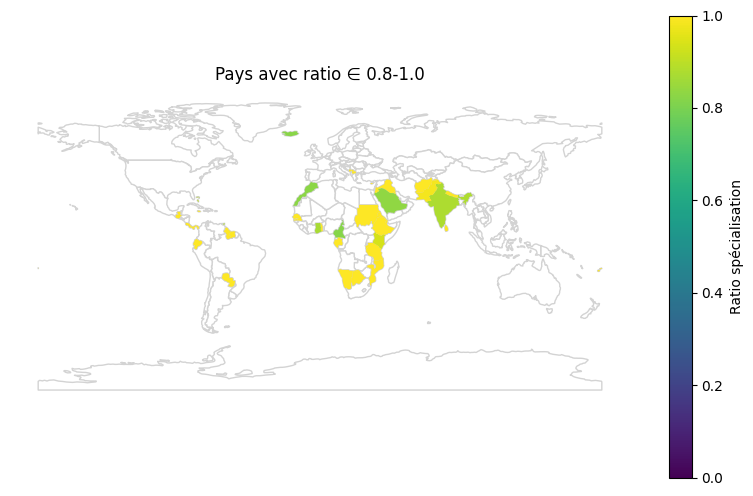

In [66]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


# 2) Tu as déjà fait la fusion et obtenu ton GeoDataFrame appelé 'merged':
#    merged = world.merge(specialisation, left_on='ISO_A3', right_on='NOC', how='left')

# 3) Créer la variable catégorielle dans merged
merged['ratio_cat'] = pd.cut(
    merged['ratio_specialisation'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    include_lowest=True,
    labels=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1.0']
)

# 4) Préparer la normalisation du cmap (0→1)
norm = Normalize(vmin=0, vmax=1)

# 5) Boucle pour générer 5 figures séparées
# DIRECTEMENT la boucle sur vos 5 classes
for cat in merged['ratio_cat'].cat.categories:
    fig, ax = plt.subplots(figsize=(10,6))
    world.plot(color='white', edgecolor='lightgrey', ax=ax)
    subset = merged[merged['ratio_cat']==cat]
    subset.plot(
      column='ratio_specialisation',
      cmap='viridis',
      norm=Normalize(0,1),
      ax=ax,
      legend=True,
      legend_kwds={'label':'Ratio spécialisation'}
    )
    ax.set_title(f'Pays avec ratio ∈ {cat}')
    ax.axis('off')
    plt.show()
    plt.close(fig)


In [74]:
pays_spe = specialisation[
    (specialisation['ratio_specialisation'] <= 1.0) &
    (specialisation['ratio_specialisation'] >= 0.8)
]

In [75]:
pays_spe.to_csv('pays_spe.csv', index=False, encoding='utf-8')